<a href="https://colab.research.google.com/github/FatihKarabas/AI-WORKS/blob/main/Bandirma_AQIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S R
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

DATA_SOURCE_MAPPING = 'bandirma-aqi-2021-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F7465914%2F11879576%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20250520%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20250520T091423Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D09dfb840b54ab01a34575ddd9a760792504000f37f38e557bfca945b7367d652f54e140db69a857c99c03e2492fc31834de259c4fd83628404271a220a25799dd2c618a25fca47e0720ad5d0b6257128d286370981f0d344ee9e840b258a9b1265572038375f389e3f172094360e17072f027a641b7624b384d225beff31affcba9163588eba9abccdfea2945f4a2a5ecd8b4198af521810ff2c234498de98f85d9fb33a72140d82f01ac8c375fe19f47fe79bd2ce72b9f7bb4cc816fe1cbdae082983d0664f8f400a61976004bc37d72de3bc42f36a36d35062b0a4954d513e727e68815f78b40d449c630f2d55c76971f7597d9409216fd979c40d94eeb444'

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'

system(paste0('sudo umount ', '/kaggle/input'))
system(paste0('sudo rmdir ', '/kaggle/input'))
system(paste0('sudo mkdir -p -- ', KAGGLE_INPUT_PATH), intern=TRUE)
system(paste0('sudo chmod 777 ', KAGGLE_INPUT_PATH), intern=TRUE)
system(
  paste0('sudo ln -sfn ', KAGGLE_INPUT_PATH,' ',file.path('..', 'input')),
  intern=TRUE)

system(paste0('sudo mkdir -p -- ', KAGGLE_WORKING_PATH), intern=TRUE)
system(paste0('sudo chmod 777 ', KAGGLE_WORKING_PATH), intern=TRUE)
system(
  paste0('sudo ln -sfn ', KAGGLE_WORKING_PATH, ' ', file.path('..', 'working')),
  intern=TRUE)

data_source_mappings = strsplit(DATA_SOURCE_MAPPING, ',')[[1]]
for (data_source_mapping in data_source_mappings) {
    path_and_url = strsplit(data_source_mapping, ':')
    directory = path_and_url[[1]][1]
    download_url = URLdecode(path_and_url[[1]][2])
    filename = sub("\\?.+", "", download_url)
    destination_path = file.path(KAGGLE_INPUT_PATH, directory)
    print(paste0('Downloading and uncompressing: ', directory))
    if (endsWith(filename, '.zip')){
      temp = tempfile(fileext = '.zip')
      download.file(download_url, temp)
      unzip(temp, overwrite = TRUE, exdir = destination_path)
      unlink(temp)
    }
    else{
      temp = tempfile(fileext = '.tar')
      download.file(download_url, temp)
      untar(temp, exdir = destination_path)
      unlink(temp)
    }
    print(paste0('Downloaded and uncompressed: ', directory))
}

print(paste0('Data source import complete'))


character(0)

character(0)

character(0)

character(0)

character(0)

character(0)

[1] "Downloading and uncompressing: bandirma-aqi-2021-2024"
[1] "Downloaded and uncompressed: bandirma-aqi-2021-2024"
[1] "Data source import complete"


In [2]:
# Gerekli k√ºt√ºphaneler
library(readxl)
library(dplyr)
library(ggplot2)
library(tidyr)
library(missForest)
library(imputeTS)
library(mice)
library(patchwork)
library(DescTools)
library(tidyverse)
library(purrr)
library(xgboost)
library(Matrix)
library(knitr)
library(reshape2)
library(zoo)


Attaching package: ‚Äòdplyr‚Äô


The following objects are masked from ‚Äòpackage:stats‚Äô:

    filter, lag


The following objects are masked from ‚Äòpackage:base‚Äô:

    intersect, setdiff, setequal, union




ERROR: Error in library(missForest): there is no package called ‚ÄòmissForest‚Äô


In [3]:
data <- read_excel("/kaggle/input/bandirma-aqi-2021-2024/Bandirma_AQ.xlsx")

In [4]:
head(data)

year month day hour pm10  so2  no2   o3    temp dwpt rhum prcp wdir wspd
1 2021 1     1   0    20.08 6.94 10.22 55.56 11.9  9.5 85    0   180  18.4
2 2021 1     1   1    18.07 8.22 12.64 51.94 11.0  9.1 88   NA   260  14.8
3 2021 1     1   2    26.32 5.63  7.98 66.38 11.0 10.1 94   NA   150   7.6
4 2021 1     1   3    25.14 2.48  4.65 69.10 10.1  9.2 94   NA   170   9.4
5 2021 1     1   4    24.23 2.08  3.49 67.40 11.0 10.1 94   NA   220   7.6
6 2021 1     1   5    24.83 1.89  6.54 59.55 10.0  9.1 94   NA   140   5.4
  pres  
1 1014.5
2 1014.0
3 1014.0
4 1014.6
5 1015.0
6 1015.0

In [5]:
str(data)

tibble [35,064 √ó 15] (S3: tbl_df/tbl/data.frame)
 $ year : num [1:35064] 2021 2021 2021 2021 2021 ...
 $ month: num [1:35064] 1 1 1 1 1 1 1 1 1 1 ...
 $ day  : num [1:35064] 1 1 1 1 1 1 1 1 1 1 ...
 $ hour : num [1:35064] 0 1 2 3 4 5 6 7 8 9 ...
 $ pm10 : num [1:35064] 20.1 18.1 26.3 25.1 24.2 ...
 $ so2  : num [1:35064] 6.94 8.22 5.63 2.48 2.08 1.89 2.32 2.25 1.72 1.32 ...
 $ no2  : num [1:35064] 10.22 12.64 7.98 4.65 3.49 ...
 $ o3   : num [1:35064] 55.6 51.9 66.4 69.1 67.4 ...
 $ temp : num [1:35064] 11.9 11 11 10.1 11 10 10.7 11 12 12 ...
 $ dwpt : num [1:35064] 9.5 9.1 10.1 9.2 10.1 9.1 9.3 10.1 9 9.6 ...
 $ rhum : num [1:35064] 85 88 94 94 94 94 91 94 82 85 ...
 $ prcp : num [1:35064] 0 NA NA NA NA NA NA NA NA NA ...
 $ wdir : num [1:35064] 180 260 150 170 220 140 170 160 180 180 ...
 $ wspd : num [1:35064] 18.4 14.8 7.6 9.4 7.6 5.4 14.8 20.5 18.4 20.5 ...
 $ pres : num [1:35064] 1014 1014 1014 1015 1015 ...


In [6]:
summary(data)

      year          month             day             hour      
 Min.   :2021   Min.   : 1.000   Min.   : 1.00   Min.   : 0.00  
 1st Qu.:2022   1st Qu.: 4.000   1st Qu.: 8.00   1st Qu.: 5.75  
 Median :2023   Median : 7.000   Median :16.00   Median :11.50  
 Mean   :2023   Mean   : 6.523   Mean   :15.73   Mean   :11.50  
 3rd Qu.:2023   3rd Qu.:10.000   3rd Qu.:23.00   3rd Qu.:17.25  
 Max.   :2024   Max.   :12.000   Max.   :31.00   Max.   :23.00  
                                                                
      pm10             so2               no2               o3        
 Min.   :  0.31   Min.   :  0.000   Min.   :  0.38   Min.   :  1.28  
 1st Qu.: 26.27   1st Qu.:  3.830   1st Qu.: 16.96   1st Qu.: 31.28  
 Median : 37.62   Median :  6.230   Median : 27.27   Median : 53.39  
 Mean   : 43.26   Mean   :  8.259   Mean   : 31.75   Mean   : 54.21  
 3rd Qu.: 53.81   3rd Qu.: 10.460   3rd Qu.: 41.70   3rd Qu.: 75.26  
 Max.   :320.89   Max.   :209.860   Max.   :178.03   Max.   

In [8]:
dim(data)

[1] 35064    15

In [9]:
colSums(is.na(data))

year month   day  hour  pm10   so2   no2    o3  temp  dwpt  rhum  prcp  wdir 
    0     0     0     0  2698  1124  1119 12180     0     0     0   286    29 
 wspd  pres 
    0   162

In [10]:
colMeans(is.na(data)) * 100

year       month         day        hour        pm10         so2 
 0.00000000  0.00000000  0.00000000  0.00000000  7.69450148  3.20556696 
        no2          o3        temp        dwpt        rhum        prcp 
 3.19130732 34.73648186  0.00000000  0.00000000  0.00000000  0.81565138 
       wdir        wspd        pres 
 0.08270591  0.00000000  0.46201232

Eksik Deƒüeri Olan S√ºtunlar ƒ∞√ßin Sayƒ± ve Y√ºzde Tablosu

In [11]:
eksik_ozet <- data.frame(
  Degisken = names(data),
  Eksik_Sayi = colSums(is.na(data)),
  Eksik_Yuzde = round(colMeans(is.na(data)) * 100, 2)
)
eksik_ozet <- eksik_ozet[eksik_ozet$Eksik_Sayi > 0, ]
print(eksik_ozet)

     Degisken Eksik_Sayi Eksik_Yuzde
pm10     pm10       2698        7.69
so2       so2       1124        3.21
no2       no2       1119        3.19
o3         o3      12180       34.74
prcp     prcp        286        0.82
wdir     wdir         29        0.08
pres     pres        162        0.46


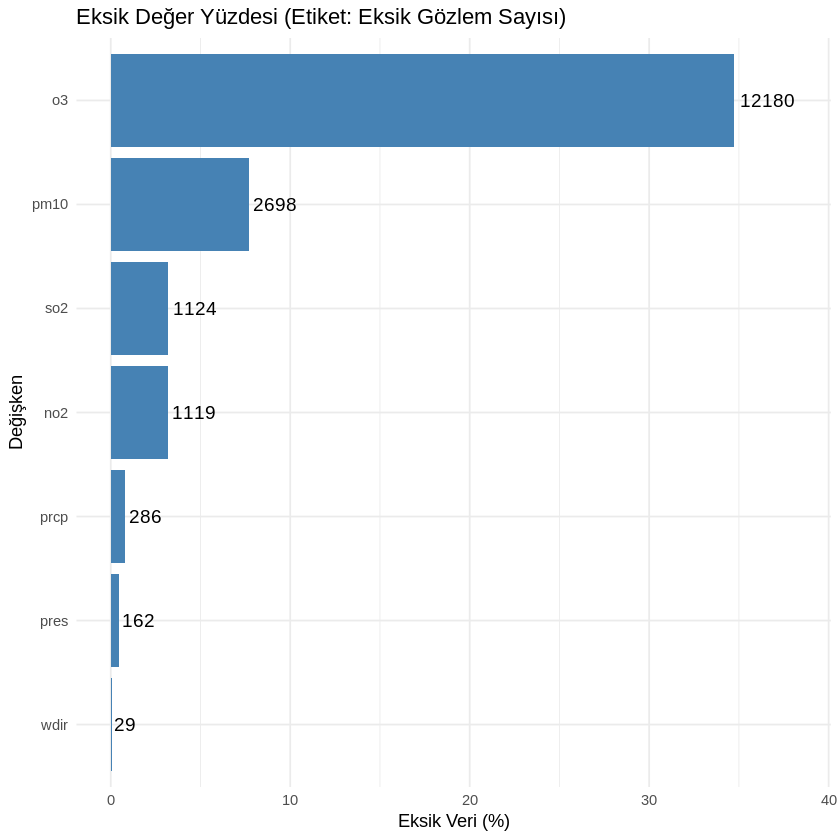

In [12]:
ggplot(eksik_ozet, aes(x = reorder(Degisken, Eksik_Yuzde), y = Eksik_Yuzde)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = Eksik_Sayi),
            hjust = -0.1, size = 4) +
  coord_flip() +
  labs(title = "Eksik Deƒüer Y√ºzdesi (Etiket: Eksik G√∂zlem Sayƒ±sƒ±)",
       x = "Deƒüi≈üken", y = "Eksik Veri (%)") +
  theme_minimal() +
  ylim(0, max(eksik_ozet$Eksik_Yuzde) * 1.1)

options(repr.plot.width = 12, repr.plot.height = 8)

In [13]:
data$datetime <- as.POSIXct(sprintf("%04d-%02d-%02d %02d:00:00",
                                    data$year, data$month, data$day, data$hour),
                            format = "%Y-%m-%d %H:%M:%S")

In [14]:
Eksik g√∂zlemleri mevsimsellik temelinde zaman serisi √ºzerinde analiz etmek,
eksik verilerin belirli mevsimlerde (ilkbahar, yaz, sonbahar, kƒ±≈ü)
sistematik bir ≈üekilde tekrar edip etmediƒüini anlamak a√ßƒ±sƒ±ndan olduk√ßa deƒüerlidir.

ERROR: Error in parse(text = input): <text>:1:7: unexpected symbol
1: Eksik g√∂zlemleri
          ^


Mevsimleri olu≈üturma

In [15]:
data <- data %>%
  mutate(
    month = as.numeric(format(datetime, "%m")),
    hour = as.numeric(format(datetime, "%H")),
    season = case_when(
      month %in% c(12, 1, 2)  ~ "Kƒ±≈ü",
      month %in% c(3, 4, 5)   ~ "ƒ∞lkbahar",
      month %in% c(6, 7, 8)   ~ "Yaz",
      month %in% c(9, 10, 11) ~ "Sonbahar"
    )
  )

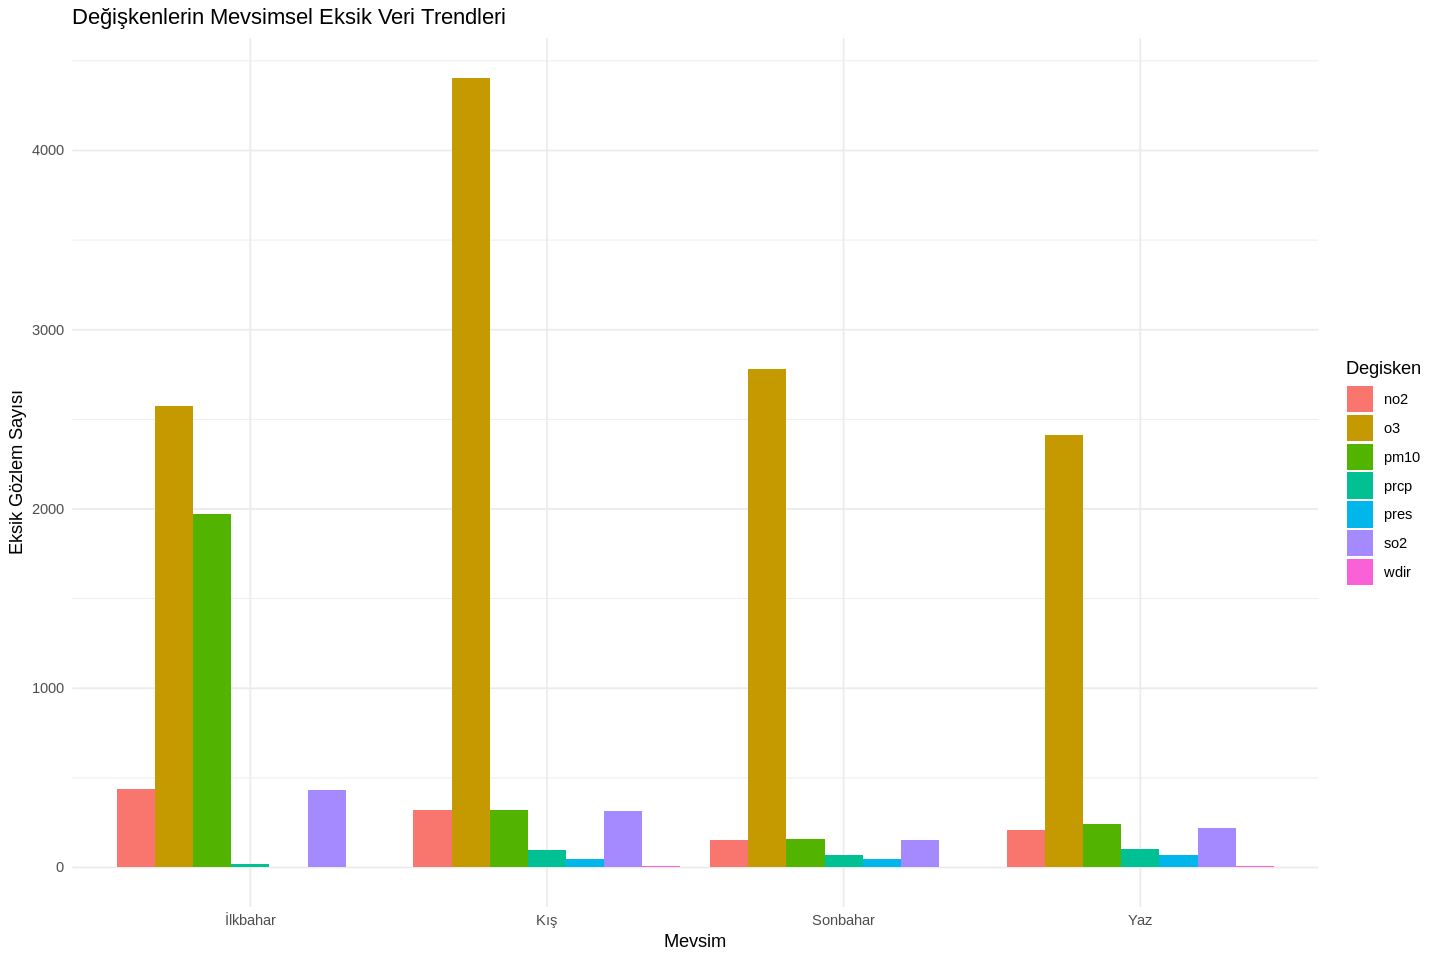

In [16]:
# Eksik veri s√ºtunlarƒ±
eksik_sezon <- data %>%
  mutate(
    across(c(pm10, so2, no2, o3, prcp, wdir, pres), ~ is.na(.), .names = "na_{.col}")
  ) %>%
  group_by(season) %>%
  summarise(across(starts_with("na_"), sum, .names = "sum_{.col}"), .groups = "drop") %>%
  pivot_longer(cols = starts_with("sum_"), names_to = "Degisken", values_to = "Eksik_Sayi") %>%
  mutate(Degisken = gsub("sum_na_", "", Degisken))

library(ggplot2)

ggplot(eksik_sezon, aes(x = season, y = Eksik_Sayi, fill = Degisken)) +
  geom_col(position = "dodge") +
  labs(title = "Deƒüi≈ükenlerin Mevsimsel Eksik Veri Trendleri",
       x = "Mevsim", y = "Eksik G√∂zlem Sayƒ±sƒ±") +
  theme_minimal()


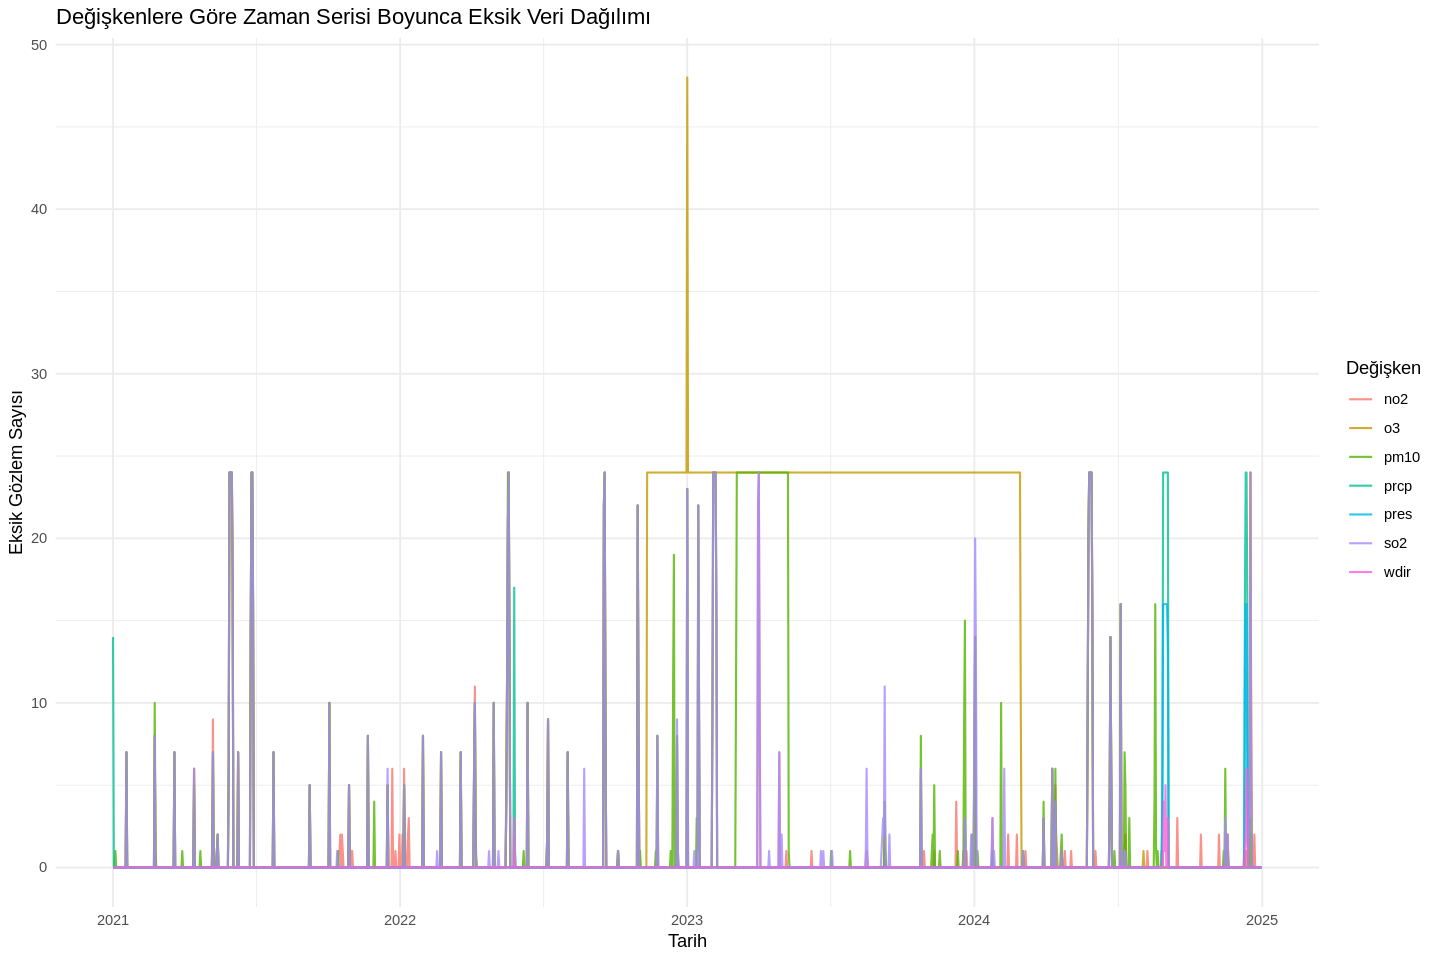

In [17]:
# G√ºnl√ºk tarih
data$day_date <- as.Date(data$datetime)

# Eksik g√∂zlem bilgilerini olu≈ütur
data_na_flags <- data %>%
  mutate(across(c(pm10, so2, no2, o3, prcp, wdir, pres),
                ~ is.na(.), .names = "na_{.col}"))

#### G√ºnl√ºk Eksik G√∂zlem Sayƒ±sƒ±nƒ± Hesapla

eksik_ts <- data_na_flags %>%
  group_by(day_date) %>%
  summarise(across(starts_with("na_"), sum), .groups = "drop") %>%
  pivot_longer(cols = starts_with("na_"),
               names_to = "Degisken", values_to = "Eksik_Sayi") %>%
  mutate(Degisken = gsub("na_", "", Degisken))

######  Zaman Serisi Grafiƒüini √áiz
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(eksik_ts, aes(x = day_date, y = Eksik_Sayi, color = Degisken)) +
  geom_line(alpha = 0.8, linewidth = 0.6) +
  labs(title = "Deƒüi≈ükenlere G√∂re Zaman Serisi Boyunca Eksik Veri Daƒüƒ±lƒ±mƒ±",
       x = "Tarih", y = "Eksik G√∂zlem Sayƒ±sƒ±", color = "Deƒüi≈üken") +
  theme_minimal()

In [19]:
options(repr.plot.width = 12, repr.plot.height = 8)
g1 <- ggplot(eksik_ts, aes(x = day_date, y = Eksik_Sayi)) +
  geom_line(color = "steelblue") +
  facet_wrap(~Degisken, scales = "free_y", ncol = 2) +
  labs(title = "Eksik Veri Zaman Serileri",
       x = "Tarih", y = "Eksik G√∂zlem Sayƒ±sƒ±") +
  theme_minimal()

# A√ßƒ±klama paneli (y = 0.5, vjust = 0.5 ile ortalanƒ±r)
g2 <- ggplot() +
  theme_void() +
  annotate("text", x = 1, y = 0.5, hjust = 0, vjust = 0.5, size = 3.5,
           label = paste(
             "üîÅ Mevsimsel desen var mƒ±? ‚Üí O3 ve PM10 i√ßin belirgin\n",
             "üõë Uzun s√ºreli eksiklik? ‚Üí O3: 2022 sonu - 2023 ortasƒ±\n",
             "üìâ Azalan eksiklik? ‚Üí WDIR, PRES\n",
             "üìà Belirli d√∂nemde eksiklik? ‚Üí NO2, SO2, PM10", sep = ""
           ))

# Y√ºkseklik oranƒ±nƒ± artƒ±r (a√ßƒ±klama i√ßin daha fazla yer)
g1 / g2 + plot_layout(heights = c(4, 1.3))

ERROR: Error in g1/g2: non-numeric argument to binary operator


# mice() (Multivariate Imputation by Chained Equations)

eksik verilerin √ßok deƒüi≈ükenli istatistiksel modeller kullanƒ±larak
doldurulmasƒ±nƒ± saƒülayan g√º√ßl√º bir R paketidir.
Temel yakla≈üƒ±mƒ±, her bir eksik deƒüi≈ükeni diƒüer deƒüi≈ükenler yardƒ±mƒ±yla
ayrƒ± ayrƒ± tahmin etmeye dayanƒ±r.
Zincirleme regresyon modeli (chained equations) ile √ßalƒ±≈üƒ±r.
Eksik veriye sahip her deƒüi≈üken i√ßin √∂zel bir tahmin modeli kurar.
Eksiklik oranƒ± y√ºksek verilerde daha g√ºvenilir sonu√ßlar √ºretir.
Mevsim, saat gibi zamansal bile≈üenler dahil edilerek tahmin g√ºc√º artƒ±rƒ±labilir.

#######  Model verisini olu≈üturma

pm10, so2, o3, prcp, no2 gibi negatif deƒüer alamaz deƒüi≈ükenleri,
mice() kullanarak yalnƒ±zca pozitif deƒüerlerle tahmin etmek.
√ñZEL TAHMƒ∞N FONKSƒ∞YONU: norm.positive

In [ ]:
library(mice)
veri_mice <- data %>%
  select(pm10, so2, no2, o3, prcp, wdir, pres, temp, rhum, wspd, hour, month, season)

veri_mice$season <- as.factor(veri_mice$season)

### Eksik verileri mice() ile tamamla
imp_all <- mice(veri_mice, m = 1, method = "norm.predict", seed = 42)

##### Tamamlanan verileri ana veri setine aktar

tamamlanan <- complete(imp_all)

data$pm10_imputed <- tamamlanan$pm10
data$so2_imputed  <- tamamlanan$so2
data$no2_imputed  <- tamamlanan$no2
data$o3_imputed   <- tamamlanan$o3
data$prcp_imputed <- tamamlanan$prcp
data$wdir_imputed <- tamamlanan$wdir
data$pres_imputed <- tamamlanan$pres


 iter imp variable
  1   1  pm10  so2  no2  o3  prcp  wdir  pres
  2   1  pm10  so2  no2  o3  prcp  wdir  pres
  3   1  pm10  so2  no2  o3  prcp  wdir  pres
  4   1  pm10  so2  no2  o3  prcp  wdir  pres
  5   1  pm10  so2  no2  o3  prcp  wdir  pres


**Yeni veri setini data_r olarak tanƒ±mla******

In [ ]:
# Yeni veri setini tanƒ±mla
data_r <- data %>%
  transmute(
    datetime = datetime,  # zaman bilgisi
    year = year,
    month = month,
    day = day,
    hour = hour,
    season = season,

    # MICE ile tamamlanmƒ±≈ü deƒüi≈ükenler
    pm10 = pm10_imputed,
    so2 = so2_imputed,
    no2 = no2_imputed,
    o3 = o3_imputed,
    prcp = prcp_imputed,
    wdir = wdir_imputed,
    pres = pres_imputed,

    # Eksiksiz olan diƒüer deƒüi≈ükenler (√∂rn: meteoroloji)
    temp = temp,
    rhum = rhum,
    wspd = wspd
  )


In [ ]:
colSums(is.na(data_r))
head(data_r, 5)
str(data_r)
summary(data_r)
dim(data_r)

datetime     year    month      day     hour   season     pm10      so2 
       0        0        0        0        0        0        0        0 
     no2       o3     prcp     wdir     pres     temp     rhum     wspd 
       0        0        0        0        0        0        0        0

datetime            year month day hour season pm10  so2  no2   o3   
1 2021-01-01 00:00:00 2021 1     1   0    Kƒ±≈ü    20.08 6.94 10.22 55.56
2 2021-01-01 01:00:00 2021 1     1   1    Kƒ±≈ü    18.07 8.22 12.64 51.94
3 2021-01-01 02:00:00 2021 1     1   2    Kƒ±≈ü    26.32 5.63  7.98 66.38
4 2021-01-01 03:00:00 2021 1     1   3    Kƒ±≈ü    25.14 2.48  4.65 69.10
5 2021-01-01 04:00:00 2021 1     1   4    Kƒ±≈ü    24.23 2.08  3.49 67.40
  prcp      wdir pres   temp rhum wspd
1 0.0000000 180  1014.5 11.9 85   18.4
2 0.2246197 260  1014.0 11.0 88   14.8
3 0.1779871 150  1014.0 11.0 94    7.6
4 0.1840040 170  1014.6 10.1 94    9.4
5 0.1709517 220  1015.0 11.0 94    7.6

tibble [35,064 √ó 16] (S3: tbl_df/tbl/data.frame)
 $ datetime: POSIXct[1:35064], format: "2021-01-01 00:00:00" "2021-01-01 01:00:00" ...
 $ year    : num [1:35064] 2021 2021 2021 2021 2021 ...
 $ month   : num [1:35064] 1 1 1 1 1 1 1 1 1 1 ...
 $ day     : num [1:35064] 1 1 1 1 1 1 1 1 1 1 ...
 $ hour    : num [1:35064] 0 1 2 3 4 5 6 7 8 9 ...
 $ season  : chr [1:35064] "Kƒ±≈ü" "Kƒ±≈ü" "Kƒ±≈ü" "Kƒ±≈ü" ...
 $ pm10    : num [1:35064] 20.1 18.1 26.3 25.1 24.2 ...
 $ so2     : num [1:35064] 6.94 8.22 5.63 2.48 2.08 1.89 2.32 2.25 1.72 1.32 ...
 $ no2     : num [1:35064] 10.22 12.64 7.98 4.65 3.49 ...
 $ o3      : num [1:35064] 55.6 51.9 66.4 69.1 67.4 ...
 $ prcp    : num [1:35064] 0 0.225 0.178 0.184 0.171 ...
 $ wdir    : num [1:35064] 180 260 150 170 220 140 170 160 180 180 ...
 $ pres    : num [1:35064] 1014 1014 1014 1015 1015 ...
 $ temp    : num [1:35064] 11.9 11 11 10.1 11 10 10.7 11 12 12 ...
 $ rhum    : num [1:35064] 85 88 94 94 94 94 91 94 82 85 ...
 $ wspd    : num [1:35064] 1

    datetime                           year          month       
 Min.   :2021-01-01 00:00:00.00   Min.   :2021   Min.   : 1.000  
 1st Qu.:2022-01-01 05:45:00.00   1st Qu.:2022   1st Qu.: 4.000  
 Median :2023-01-01 05:30:00.00   Median :2023   Median : 7.000  
 Mean   :2023-01-01 05:30:14.77   Mean   :2023   Mean   : 6.523  
 3rd Qu.:2023-12-31 17:15:00.00   3rd Qu.:2023   3rd Qu.:10.000  
 Max.   :2024-12-31 23:00:00.00   Max.   :2024   Max.   :12.000  
      day             hour          season               pm10        
 Min.   : 1.00   Min.   : 0.00   Length:35064       Min.   : -2.257  
 1st Qu.: 8.00   1st Qu.: 5.75   Class :character   1st Qu.: 27.058  
 Median :16.00   Median :11.50   Mode  :character   Median : 38.790  
 Mean   :15.73   Mean   :11.50                      Mean   : 43.690  
 3rd Qu.:23.00   3rd Qu.:17.25                      3rd Qu.: 54.220  
 Max.   :31.00   Max.   :23.00                      Max.   :320.890  
      so2               no2               o3    

[1] 35064    16

In [ ]:

data_r[names(data_r) != "temp"] <- lapply(data_r[names(data_r) != "temp"], function(x) {
  if (is.numeric(x)) ifelse(x < 0, 0, x) else x
})

"temp" deƒüi≈ükeni hari√ß negatif deƒüer olmadƒ±ƒüƒ±nƒ± kontrol et

In [ ]:
summary(data_r)
sapply(data_r, function(x) any(x < 0, na.rm = TRUE))

    datetime                           year          month       
 Min.   :2021-01-01 00:00:00.00   Min.   :2021   Min.   : 1.000  
 1st Qu.:2022-01-01 05:45:00.00   1st Qu.:2022   1st Qu.: 4.000  
 Median :2023-01-01 05:30:00.00   Median :2023   Median : 7.000  
 Mean   :2023-01-01 05:30:14.77   Mean   :2023   Mean   : 6.523  
 3rd Qu.:2023-12-31 17:15:00.00   3rd Qu.:2023   3rd Qu.:10.000  
 Max.   :2024-12-31 23:00:00.00   Max.   :2024   Max.   :12.000  
      day             hour          season               pm10       
 Min.   : 1.00   Min.   : 0.00   Length:35064       Min.   :  0.00  
 1st Qu.: 8.00   1st Qu.: 5.75   Class :character   1st Qu.: 27.06  
 Median :16.00   Median :11.50   Mode  :character   Median : 38.79  
 Mean   :15.73   Mean   :11.50                      Mean   : 43.69  
 3rd Qu.:23.00   3rd Qu.:17.25                      3rd Qu.: 54.22  
 Max.   :31.00   Max.   :23.00                      Max.   :320.89  
      so2               no2               o3           

datetime     year    month      day     hour   season     pm10      so2 
   FALSE    FALSE    FALSE    FALSE    FALSE    FALSE    FALSE    FALSE 
     no2       o3     prcp     wdir     pres     temp     rhum     wspd 
   FALSE    FALSE    FALSE    FALSE    FALSE     TRUE    FALSE    FALSE


**Aykƒ±rƒ± Deger Analizi**

In [ ]:

# T√ºm sayƒ±sal s√ºtunlarƒ± se√ß
sayisal_deg <- data_r %>% select(where(is.numeric)) %>% names()

# Z-score hesapla ve aykƒ±rƒ±larƒ± i≈üaretle
for (var in sayisal_deg) {
  data_r[[paste0(var, "_z")]] <- scale(data_r[[var]])
  data_r[[paste0(var, "_z_outlier")]] <- abs(data_r[[paste0(var, "_z")]]) > 3
}

# Z-score tabanlƒ± aykƒ±rƒ± √∂zet:
zscore_ozet <- data.frame(
  Degisken = gsub("_z_outlier", "", grep("_z_outlier$", names(data_r), value = TRUE)),
  Aykiri_Sayi = sapply(grep("_z_outlier$", names(data_r), value = TRUE),
                       function(col) sum(data_r[[col]], na.rm = TRUE)),
  Toplam = nrow(data_r)
) %>%
  mutate(Aykiri_Yuzde = round(100 * Aykiri_Sayi / Toplam, 2)) %>%
  filter(Aykiri_Sayi > 0)  # üîç 0 olanlarƒ± √ßƒ±kar

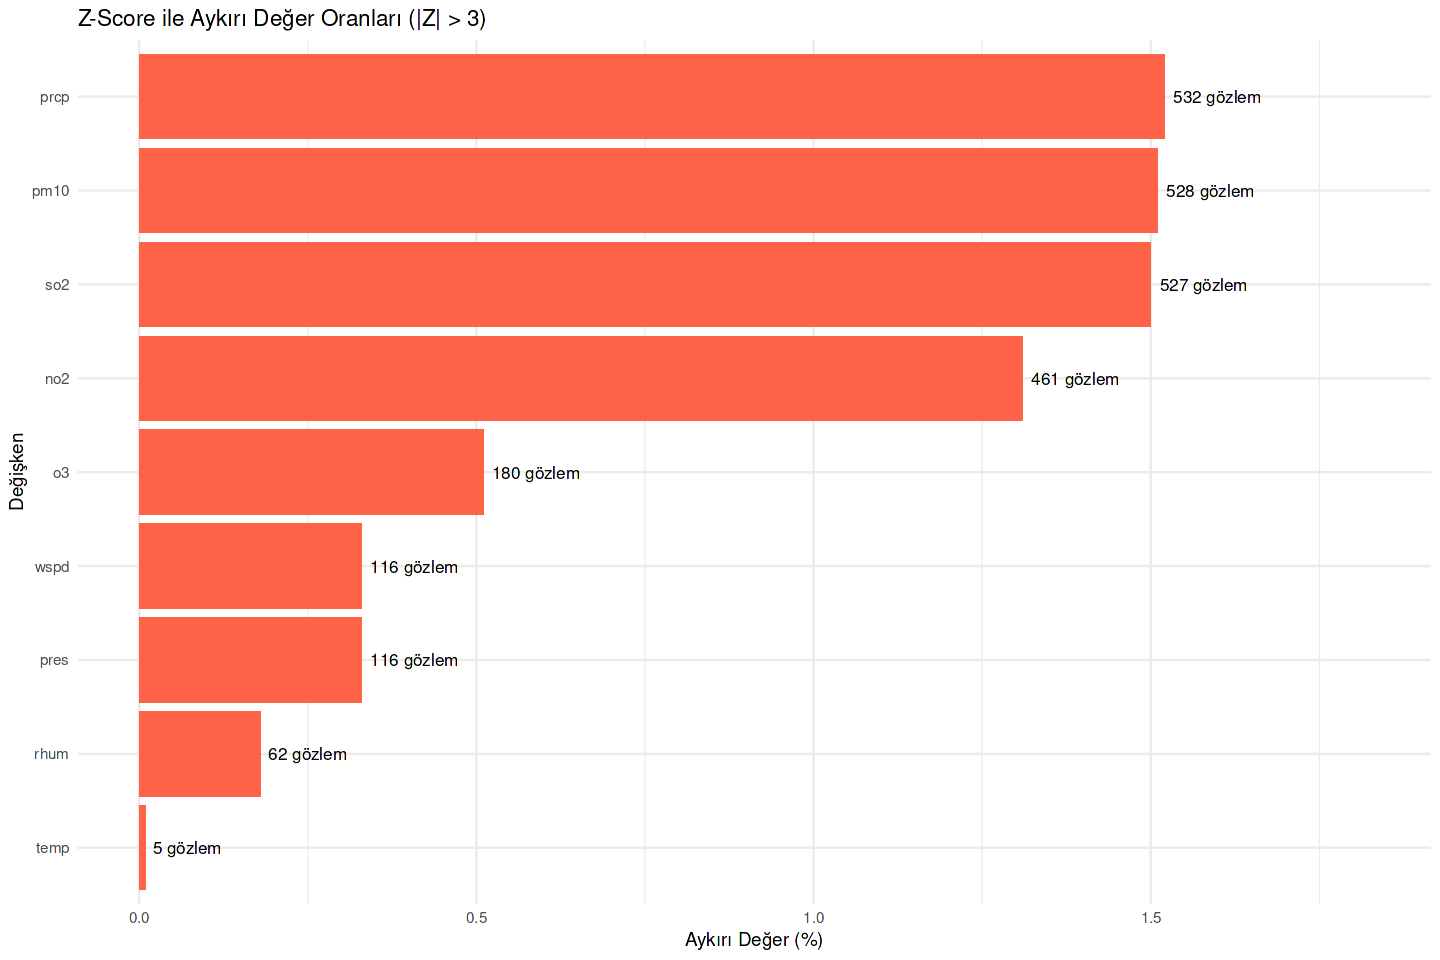

In [ ]:
# Barplot
# Y√ºkseklik ve geni≈ülik ayarƒ± (√∂rneƒüin: 12 x 8 in√ß)
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(zscore_ozet, aes(x = reorder(Degisken, Aykiri_Yuzde), y = Aykiri_Yuzde)) +
  geom_col(fill = "tomato") +
  geom_text(aes(label = paste0(Aykiri_Sayi, " g√∂zlem")),
            hjust = -0.1, size = 3.5) +
  coord_flip() +
  labs(title = "Z-Score ile Aykƒ±rƒ± Deƒüer Oranlarƒ± (|Z| > 3)",
       x = "Deƒüi≈üken", y = "Aykƒ±rƒ± Deƒüer (%)") +
  theme_minimal() +
  ylim(0, max(zscore_ozet$Aykiri_Yuzde) * 1.2)


**IQR**********

In [ ]:
# ƒ∞stenen deƒüi≈ükenler
tum_degiskenler <- c("pm10", "so2", "no2", "o3", "temp", "dwpt",
                     "rhum", "prcp", "wdir", "wspd", "pres")

# Sadece veri setinde mevcut olanlarƒ± al
gecerli_degiskenler <- tum_degiskenler[tum_degiskenler %in% names(data_r)]
print(gecerli_degiskenler)

for (deg in gecerli_degiskenler) {
  Q1 <- quantile(data_r[[deg]], 0.25, na.rm = TRUE)
  Q3 <- quantile(data_r[[deg]], 0.75, na.rm = TRUE)
  IQR_val <- Q3 - Q1
  alt <- Q1 - 1.5 * IQR_val
  ust <- Q3 + 1.5 * IQR_val
  data_r[[paste0(deg, "_iqr_outlier")]] <- data_r[[deg]] < alt | data_r[[deg]] > ust
}

iqr_cols <- paste0(gecerli_degiskenler, "_iqr_outlier")

iqr_ozet <- data.frame(
  Degisken = gecerli_degiskenler,
  Aykiri_Sayi = sapply(iqr_cols, function(col) sum(data_r[[col]], na.rm = TRUE)),
  Toplam = nrow(data_r)
) %>%
  mutate(Aykiri_Yuzde = round(100 * Aykiri_Sayi / Toplam, 2)) %>%
  filter(Aykiri_Sayi > 0)

 [1] "pm10" "so2"  "no2"  "o3"   "temp" "rhum" "prcp" "wdir" "wspd" "pres"


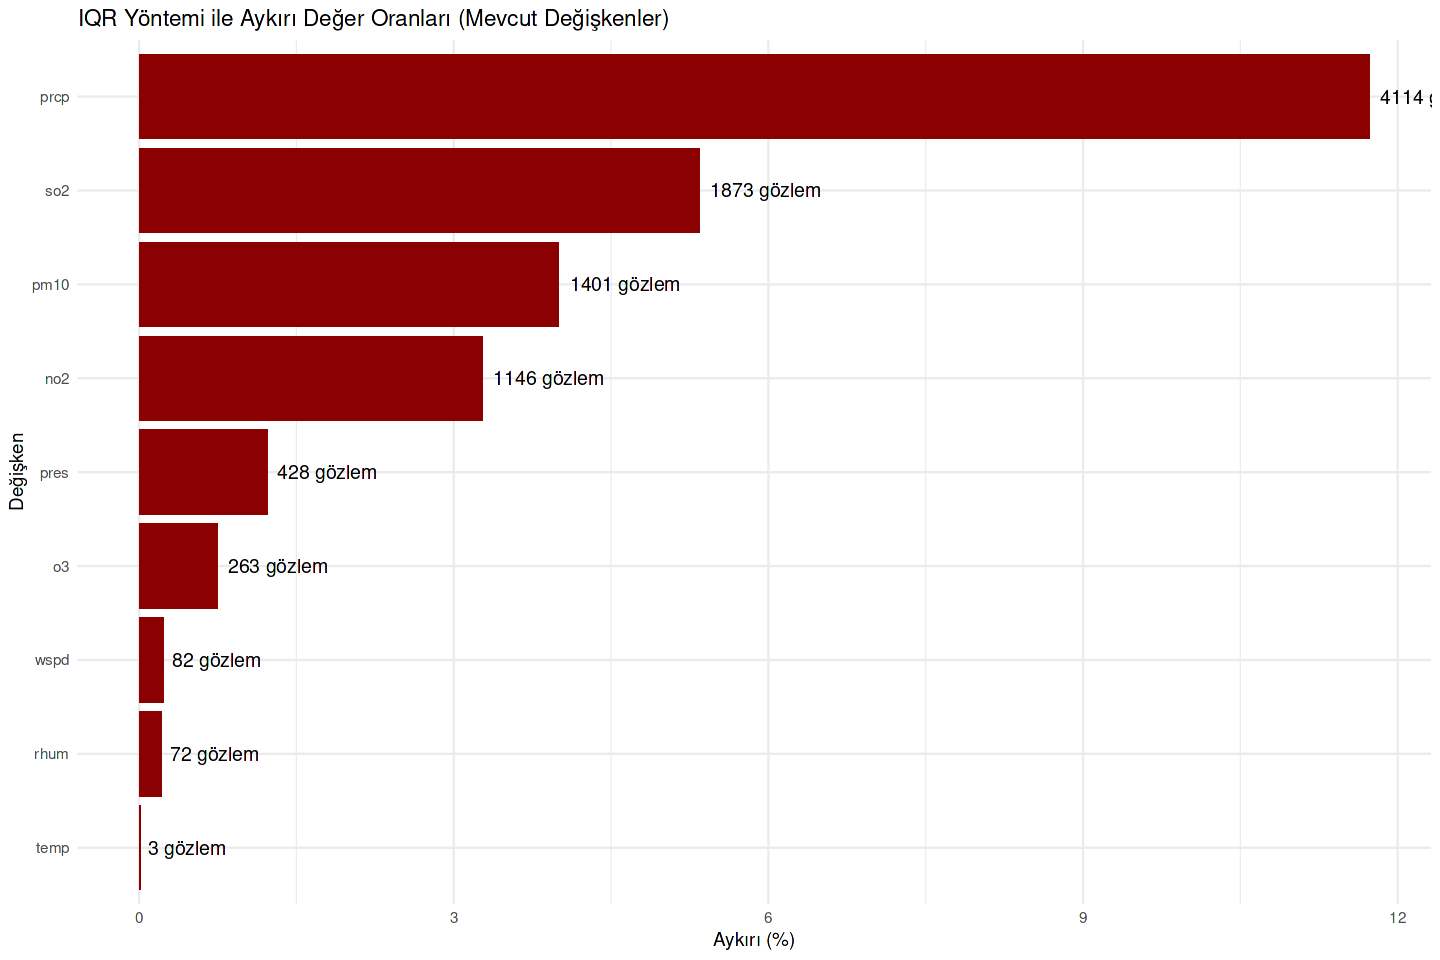

In [ ]:
# Y√ºkseklik ve geni≈ülik ayarƒ± (√∂rneƒüin: 12 x 8 in√ß)
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(iqr_ozet, aes(x = reorder(Degisken, Aykiri_Yuzde), y = Aykiri_Yuzde)) +
  geom_col(fill = "darkred") +
  geom_text(aes(label = paste0(Aykiri_Sayi, " g√∂zlem")),
            hjust = -0.1, size = 4) +
  coord_flip() +
  labs(title = "IQR Y√∂ntemi ile Aykƒ±rƒ± Deƒüer Oranlarƒ± (Mevcut Deƒüi≈ükenler)",
       x = "Deƒüi≈üken", y = "Aykƒ±rƒ± (%)") +
  theme_minimal()

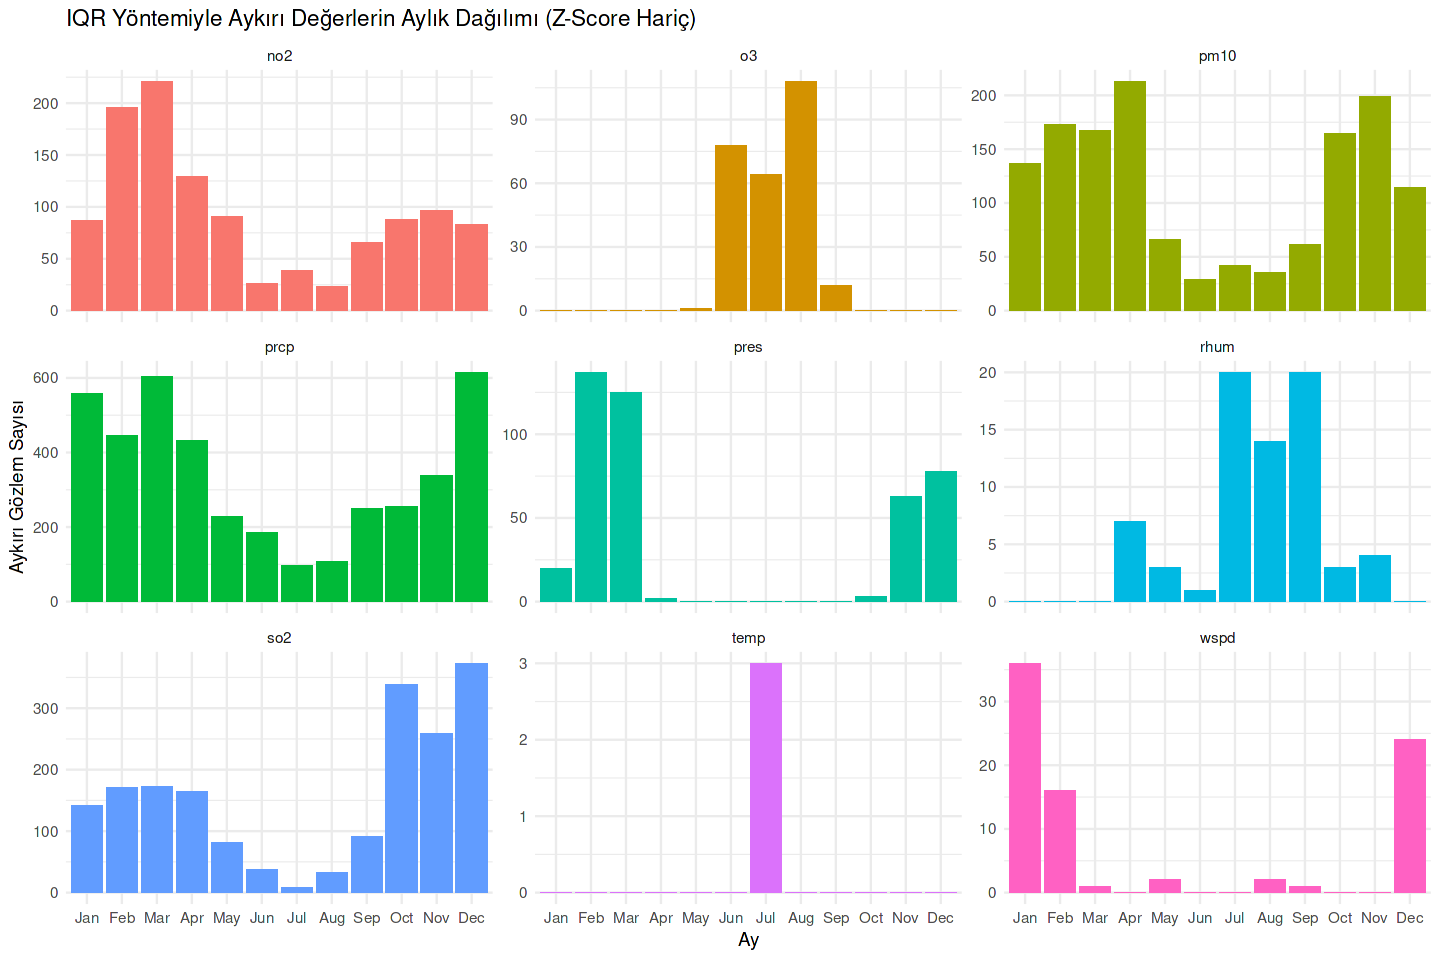

In [ ]:
######## IQR  aykƒ±rƒ± deƒüerlerin aylara g√∂re daƒüƒ±lƒ±mƒ±

library(dplyr)
library(ggplot2)

# üîç 1. Sadece _iqr_outlier ile biten ve _z i√ßermeyen s√ºtunlarƒ± se√ß
iqr_cols <- names(data_r)
iqr_outlier_cols <- iqr_cols[grepl("_iqr_outlier$", iqr_cols) & !grepl("_z", iqr_cols)]

# üîé 2. En az bir aykƒ±rƒ± g√∂zlem i√ßerenleri filtrele
iqr_outlier_cols_aktif <- iqr_outlier_cols[sapply(iqr_outlier_cols, function(col) {
  sum(data_r[[col]], na.rm = TRUE) > 0
})]

# Aylƒ±k aykƒ±rƒ± sayƒ±sƒ±nƒ± hesapla
iqr_aylik_ozet <- lapply(iqr_outlier_cols_aktif, function(col) {
  degisken_adi <- gsub("_iqr_outlier", "", col)
  data_r %>%
    mutate(month = factor(month, levels = 1:12, labels = month.abb)) %>%
    group_by(month) %>%
    summarise(Aykiri_Sayi = sum(.data[[col]], na.rm = TRUE), .groups = "drop") %>%
    mutate(Degisken = degisken_adi)
}) %>%
  bind_rows()
# Y√ºkseklik ve geni≈ülik ayarƒ± (√∂rneƒüin: 12 x 8 in√ß)
options(repr.plot.width = 12, repr.plot.height = 8)

ggplot(iqr_aylik_ozet, aes(x = month, y = Aykiri_Sayi, fill = Degisken)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~Degisken, scales = "free_y") +
  labs(title = "IQR Y√∂ntemiyle Aykƒ±rƒ± Deƒüerlerin Aylƒ±k Daƒüƒ±lƒ±mƒ± (Z-Score Hari√ß)",
       x = "Ay", y = "Aykƒ±rƒ± G√∂zlem Sayƒ±sƒ±") +
  theme_minimal()

**AQI HESAPLAMA**#

T√ºrkiye Ulusal Hava Kalitesi ƒ∞ndeksi‚Äôni olu≈ütururken, US-EPA Hava Kalitesi ƒ∞ndeksi‚Äôni ulusal mevzuat ve sƒ±nƒ±r deƒüerleriyle uyumlu hale getirmi≈ütir.

ƒ∞ndeksi belirleyen hava kirletici maddeler,

partik√ºl madde (PM10), (24 saatlik ortalama)

karbon monoksit (CO), (8 saatlik ortalama)(Bandƒ±rma verileri bulunamadƒ±)

azot dioksit (NO2), (1 saatlik ortalama)

k√ºk√ºrt dioksit (SO2) (1 saatlik ortalama)

ozon (O3)(8 saatlik ortalama)

-PM2.5 i√ßin sƒ±nƒ±r deƒüerinin hen√ºz bulunmamasƒ±dƒ±r.

S√∂z parametreler www.havaizleme.gov.tr adresinden anlƒ±k olarak takip edilebilmektedir

![image.png](attachment:152d5c6d-5f1c-4423-a67c-65bcea9da89b.png)![image.png]

In [ ]:
#  Ulusal T√ºrkiye HKƒ∞ Kesme Noktalarƒ±nƒ±n Tanƒ±mlanmasƒ±

# T√ºrkiye Ulusal HKƒ∞ Kesme Noktalarƒ±
hki_araliklari <- list(
  pm10 = data.frame(
    I_lo = c(0, 51, 101, 151, 201, 301),
    I_hi = c(50, 100, 150, 200, 300, 500),
    BP_lo = c(0, 51, 101, 151, 201, 301),
    BP_hi = c(50, 100, 150, 200, 300, 500)
  ),
  so2 = data.frame(
    I_lo = c(0, 51, 101, 151, 201, 301),
    I_hi = c(50, 100, 150, 200, 300, 500),
    BP_lo = c(0, 51, 101, 151, 201, 301),
    BP_hi = c(50, 100, 150, 200, 300, 500)
  ),
  no2 = data.frame(
    I_lo = c(0, 51, 101, 151, 201, 301),
    I_hi = c(50, 100, 150, 200, 300, 500),
    BP_lo = c(0, 101, 201, 400, 800, 1600),
    BP_hi = c(100, 200, 399, 799, 1599, 2000)
  ),
  o3 = data.frame(
    I_lo = c(0, 51, 101, 151, 201, 301),
    I_hi = c(50, 100, 150, 200, 300, 500),
    BP_lo = c(0, 121, 181, 241, 401, 801),
    BP_hi = c(120, 180, 240, 400, 800, 1000)
  )
)

![image.png](attachment:99dab227-ed81-481a-a7ef-04ab72a81035.png)![image.png]

In [ ]:
# HKƒ∞ Hesaplama Fonksiyonu

hesapla_hki <- function(c, pollutant) {
  if (is.na(c)) return(NA)  # Eksik g√∂zlemler i√ßin
  aralik <- hki_araliklari[[pollutant]]
  for (i in 1:nrow(aralik)) {
    if (c >= aralik$BP_lo[i] && c <= aralik$BP_hi[i]) {
      return(
        (aralik$I_hi[i] - aralik$I_lo[i]) / (aralik$BP_hi[i] - aralik$BP_lo[i]) *
          (c - aralik$BP_lo[i]) + aralik$I_lo[i]
      )
    }
  }
  return(NA)  # Eƒüer hi√ßbir aralƒ±ƒüa girmiyorsa
}

#  Ortalama S√ºreler ve HKƒ∞ S√ºtunlarƒ±nƒ±n Olu≈üturulmasƒ±

library(dplyr)
library(zoo)  # rollmean fonksiyonu i√ßin

data_hki <- data_r %>%
  arrange(datetime) %>%
  mutate(
    pm10_avg = zoo::rollmean(pm10, k = 24, fill = NA, align = "right"),
    o3_avg   = zoo::rollmean(o3,   k = 8,  fill = NA, align = "right"),
    so2_avg  = so2,
    no2_avg  = no2
  ) %>%
  rowwise() %>%
  mutate(
    pm10_AQI = hesapla_hki(pm10_avg, "pm10"),
    o3_AQI   = hesapla_hki(o3_avg, "o3"),
    so2_AQI  = hesapla_hki(so2_avg, "so2"),
    no2_AQI  = hesapla_hki(no2_avg, "no2"),
    gen_AQI  = max(c(pm10_AQI, o3_AQI, so2_AQI, no2_AQI), na.rm = TRUE)
  ) %>%
  ungroup()


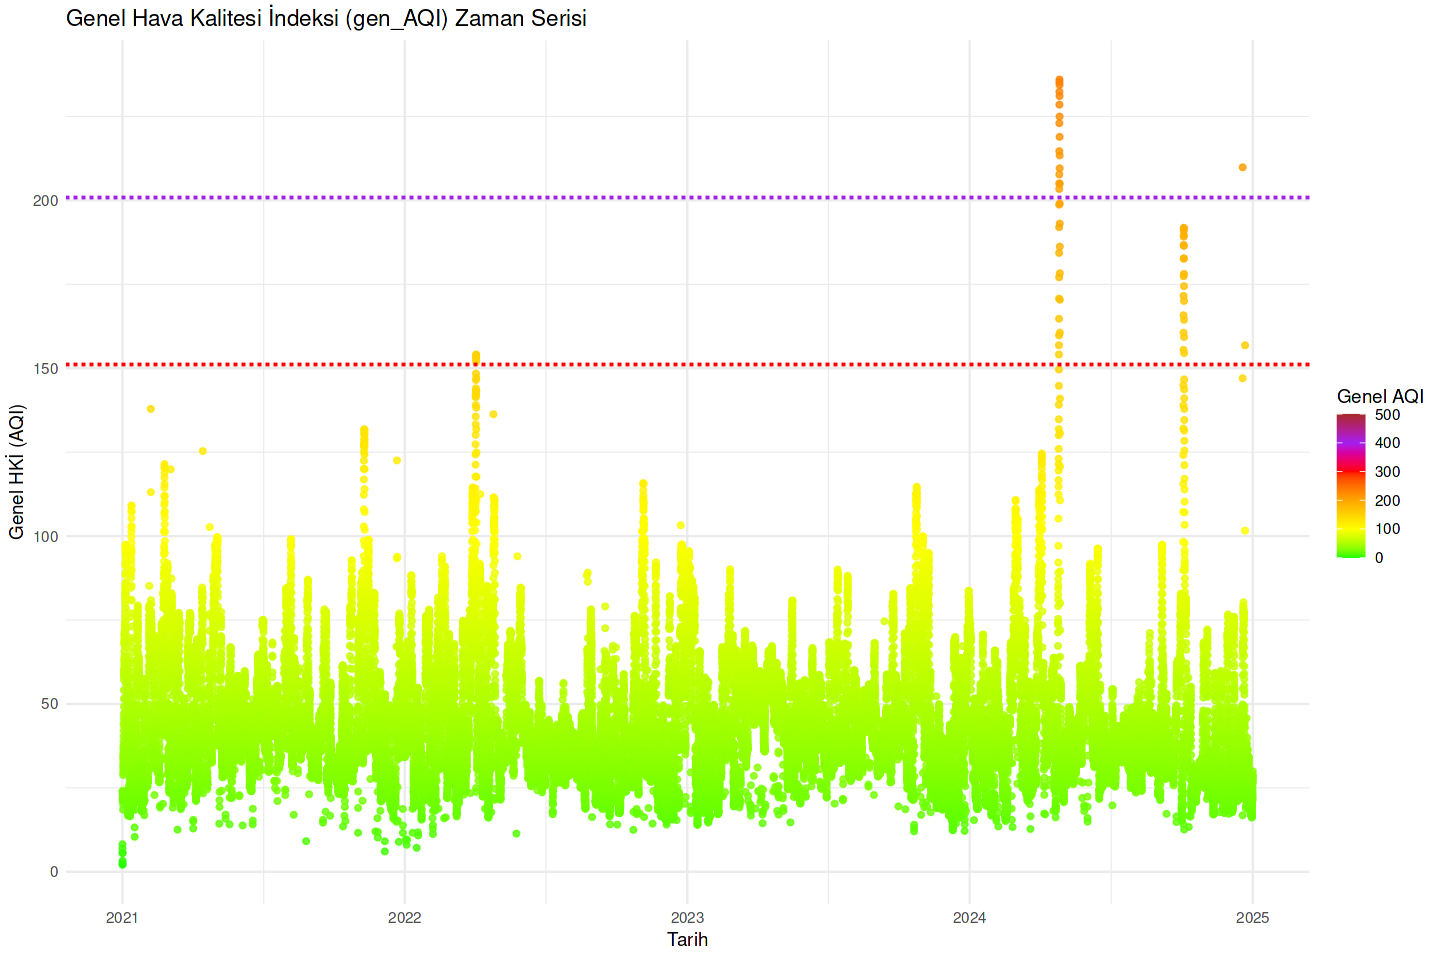

In [ ]:
library(ggplot2)

ggplot(data_hki, aes(x = datetime, y = gen_AQI, color = gen_AQI)) +
  geom_point(size = 1.2, alpha = 0.8) +
  scale_color_gradientn(
    colors = c("green", "yellow", "orange", "red", "purple", "brown"),
    limits = c(0, 500),
    name = "Genel AQI"
  ) +
  geom_hline(yintercept = 151, color = "red", linetype = "dashed", linewidth = 0.8) +
  geom_hline(yintercept = 201, color = "purple", linetype = "dashed", linewidth = 0.8) +
  labs(
    title = "Genel Hava Kalitesi ƒ∞ndeksi (gen_AQI) Zaman Serisi",
    x = "Tarih",
    y = "Genel HKƒ∞ (AQI)"
  ) +
  theme_minimal()

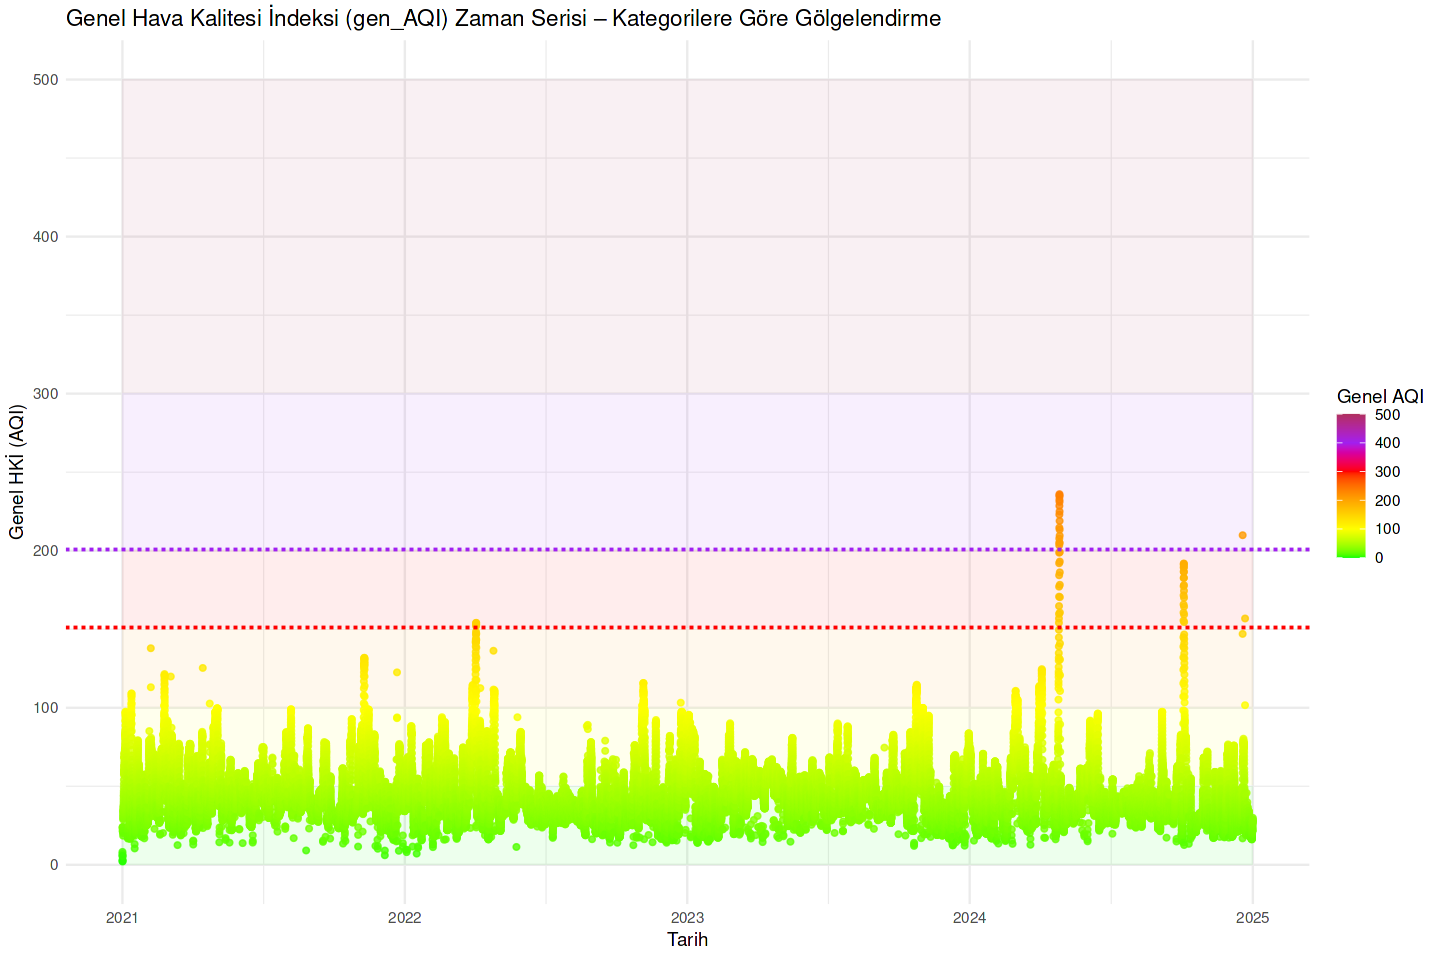

In [ ]:
library(ggplot2)

ggplot(data_hki, aes(x = datetime, y = gen_AQI)) +

  # G√∂lgelendirme katmanlarƒ± (her kategori i√ßin geom_rect)
  annotate("rect", xmin = min(data_hki$datetime), xmax = max(data_hki$datetime),
           ymin = 0, ymax = 50, fill = "green", alpha = 0.07) +
  annotate("rect", xmin = min(data_hki$datetime), xmax = max(data_hki$datetime),
           ymin = 51, ymax = 100, fill = "yellow", alpha = 0.07) +
  annotate("rect", xmin = min(data_hki$datetime), xmax = max(data_hki$datetime),
           ymin = 101, ymax = 150, fill = "orange", alpha = 0.07) +
  annotate("rect", xmin = min(data_hki$datetime), xmax = max(data_hki$datetime),
           ymin = 151, ymax = 200, fill = "red", alpha = 0.07) +
  annotate("rect", xmin = min(data_hki$datetime), xmax = max(data_hki$datetime),
           ymin = 201, ymax = 300, fill = "purple", alpha = 0.07) +
  annotate("rect", xmin = min(data_hki$datetime), xmax = max(data_hki$datetime),
           ymin = 301, ymax = 500, fill = "maroon", alpha = 0.07) +

  # Nokta grafiƒüi
  geom_point(aes(color = gen_AQI), size = 1.2, alpha = 0.8) +

  # Renk skalasƒ±
  scale_color_gradientn(
    colors = c("green", "yellow", "orange", "red", "purple", "maroon"),
    limits = c(0, 500),
    name = "Genel AQI"
  ) +

  # E≈üik √ßizgileri
  geom_hline(yintercept = 151, color = "red", linetype = "dashed", linewidth = 0.8) +
  geom_hline(yintercept = 201, color = "purple", linetype = "dashed", linewidth = 0.8) +

  # Etiketler
  labs(
    title = "Genel Hava Kalitesi ƒ∞ndeksi (gen_AQI) Zaman Serisi ‚Äì Kategorilere G√∂re G√∂lgelendirme",
    x = "Tarih",
    y = "Genel HKƒ∞ (AQI)"
  ) +
  theme_minimal()

Hangi Kirletici Ka√ß Kere En Y√ºksek Olmu≈ü?

In [ ]:
data_hki <- data_hki %>%
  mutate(
    max_kirletici = pmap_chr(
      list(pm10_AQI, so2_AQI, no2_AQI, o3_AQI),
      function(pm10, so2, no2, o3) {
        kirleticiler <- c(pm10 = pm10, so2 = so2, no2 = no2, o3 = o3)
        if (all(is.na(kirleticiler))) return(NA_character_)
        names(kirleticiler)[which.max(kirleticiler)]
      }
    )
  )
table(data_hki$max_kirletici)


  no2    o3  pm10   so2 
 1540  6109 27181   234 

**Genel AQI Degerine En Fazla Etki Eden Kirletici**

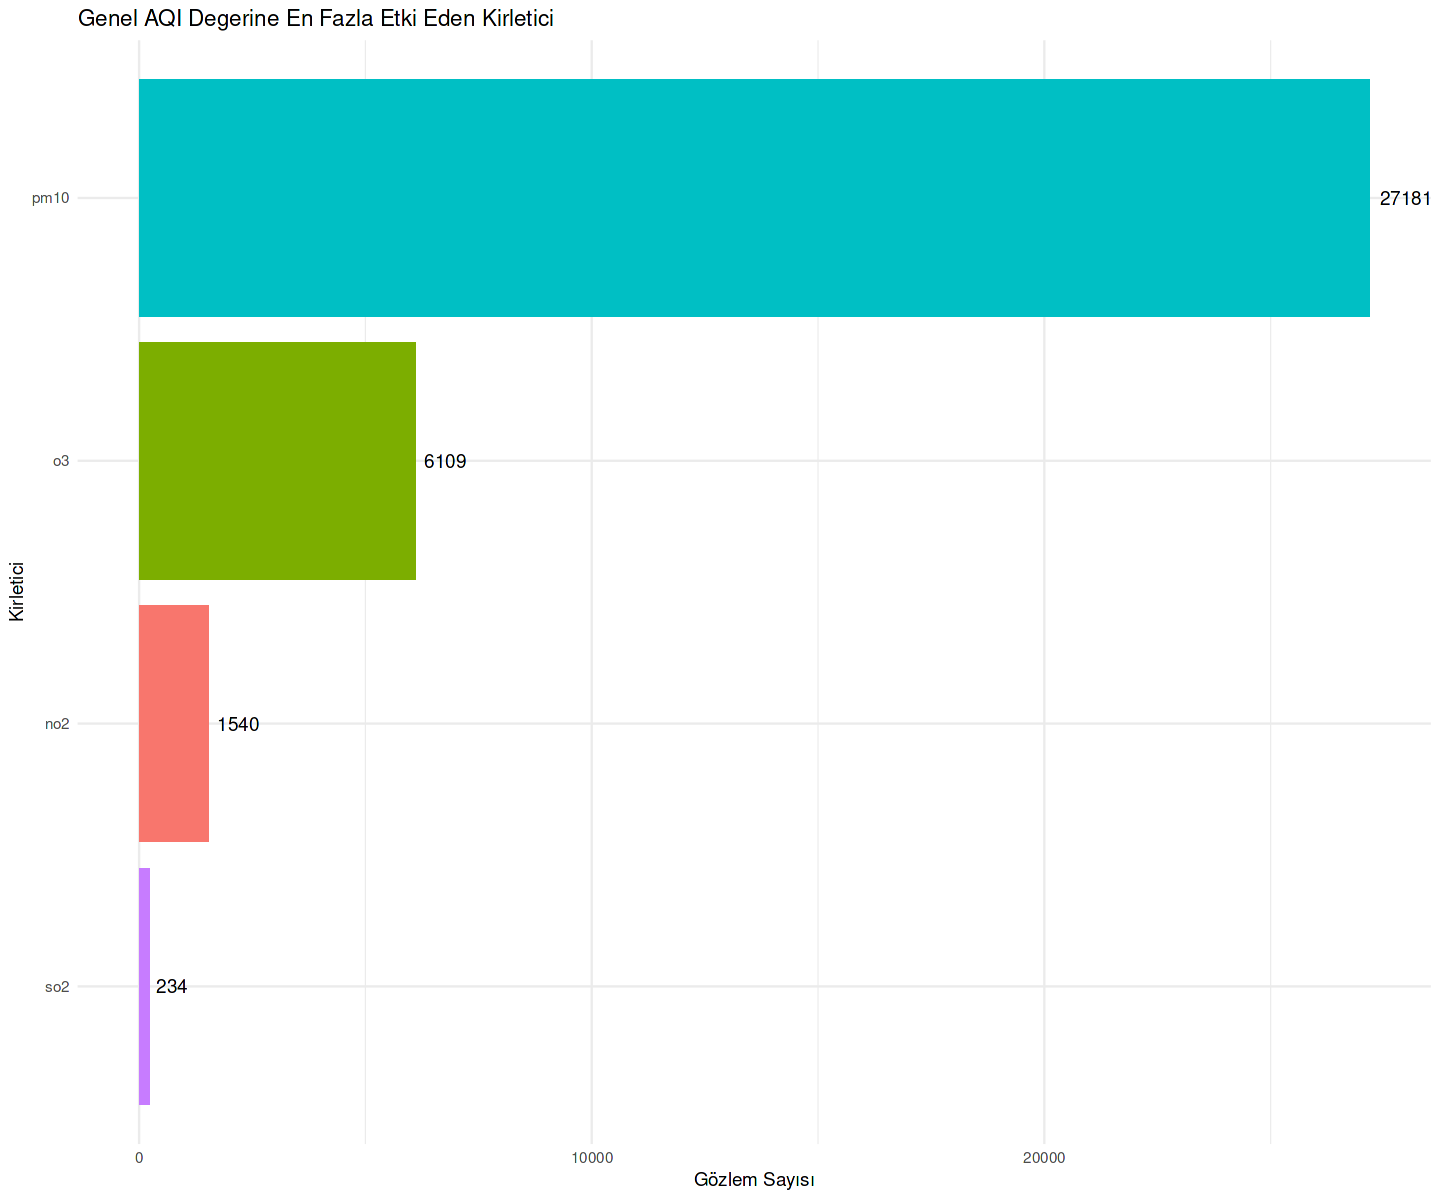

In [ ]:
library(ggplot2)
options(repr.plot.width = 12, repr.plot.height = 10)
data_hki %>%
  filter(!is.na(max_kirletici)) %>%
  count(max_kirletici) %>%
  ggplot(aes(x = reorder(max_kirletici, n), y = n, fill = max_kirletici)) +
  geom_col(show.legend = FALSE) +
  geom_text(aes(label = n), hjust = -0.2) +
  coord_flip() +
  labs(
    title = "Genel AQI Degerine En Fazla Etki Eden Kirletici",
    x = "Kirletici", y = "G√∂zlem Sayƒ±sƒ±"
  ) +
  theme_minimal()

In [ ]:
model_df <- data_hki %>%
  select(gen_AQI, temp, rhum, wspd, pres) %>%
  filter(complete.cases(.))


model <- lm(gen_AQI ~ temp + rhum + wspd + pres, data = model_df)
summary(model)


Call:
lm(formula = gen_AQI ~ temp + rhum + wspd + pres, data = model_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.748 -11.701  -3.397   7.971 186.490 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 245.59193   18.49929  13.276   <2e-16 ***
temp          0.04318    0.01719   2.513    0.012 *  
rhum         -0.09103    0.00722 -12.608   <2e-16 ***
wspd         -0.46499    0.00886 -52.483   <2e-16 ***
pres         -0.18419    0.01795 -10.262   <2e-16 ***
---
Signif. codes:  0 ‚Äò***‚Äô 0.001 ‚Äò**‚Äô 0.01 ‚Äò*‚Äô 0.05 ‚Äò.‚Äô 0.1 ‚Äò ‚Äô 1

Residual standard error: 17.94 on 35059 degrees of freedom
Multiple R-squared:  0.08031,	Adjusted R-squared:  0.08021 
F-statistic: 765.4 on 4 and 35059 DF,  p-value: < 2.2e-16


**XGBoost **

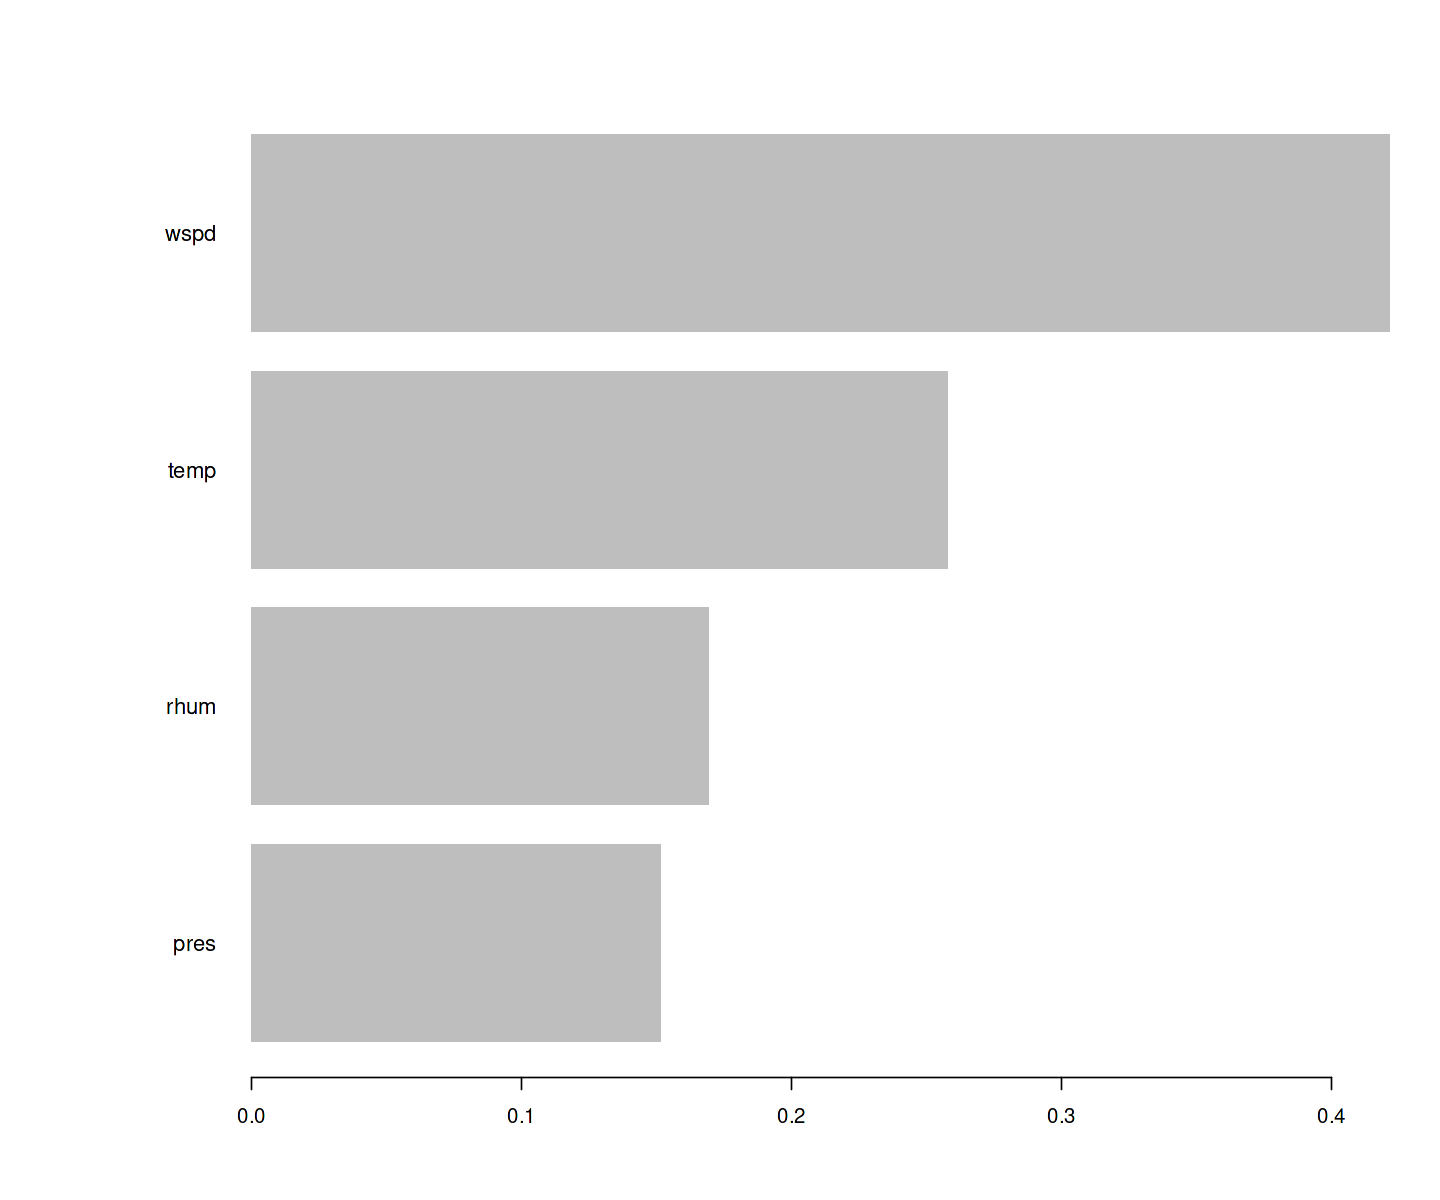

In [ ]:
library(xgboost)

# Gerekli deƒüi≈ükenler ve eksik veri temizliƒüi
xgb_df <- data_hki %>%
  select(gen_AQI, temp, rhum, wspd, pres) %>%
  filter(complete.cases(.))

# Baƒüƒ±mlƒ± ve baƒüƒ±msƒ±z deƒüi≈ükenleri ayƒ±r
y <- xgb_df$gen_AQI
x <- xgb_df %>% select(-gen_AQI) %>% as.matrix()

dtrain <- xgb.DMatrix(data = x, label = y)

set.seed(42)
xgb_model <- xgboost(
  data = dtrain,
  objective = "reg:squarederror",
  nrounds = 100,
  eta = 0.1,
  max_depth = 4,
  verbose = 0
)

importance <- xgb.importance(model = xgb_model)
xgb.plot.importance(importance_matrix = importance)


In [ ]:
karsilastirma <- data.frame(
  Ozellik = c("Ruzgar (wspd)", "Sicaklik (temp)", "Nem (rhum)", "Basinc (pres)"),
  Regresyon_Modeli = c("En guclu negatif etki",
                       "Anlamli ama kucuk etki",
                       "Anlamli negatif etki",
                       "Anlamli negatif etki"),
  XGBoost = c("En yuksek onem",
              "Orta duzey katkƒ±",
              "Orta duzey katkƒ±",
              "Gorece daha az etkili")
)

library(knitr)
kable(karsilastirma, format = "markdown", caption = "Karsilastirmali Yorum: XGBoost vs Regresyon")




Table: Karsilastirmali Yorum: XGBoost vs Regresyon

|Ozellik         |Regresyon_Modeli       |XGBoost               |
|:---------------|:----------------------|:---------------------|
|Ruzgar (wspd)   |En guclu negatif etki  |En yuksek onem        |
|Sicaklik (temp) |Anlamli ama kucuk etki |Orta duzey katkƒ±      |
|Nem (rhum)      |Anlamli negatif etki   |Orta duzey katkƒ±      |
|Basinc (pres)   |Anlamli negatif etki   |Gorece daha az etkili |

pm10_AQI hedef deƒüi≈ükeni ile meteorolojik deƒüi≈ükenler (temp, rhum, wspd, pres)
arasƒ±ndaki ili≈ükiyi √ßoklu doƒürusal regresyon (multiple linear regression)
kullanarak adƒ±m adƒ±m analiz edeceƒüimiz

In [ ]:
regresyon_veri <- data_r %>%
  select(pm10_AQI, temp, rhum, wspd, pres) %>%
  na.omit()  # Eksik deƒüer varsa kaldƒ±r

# √áoklu doƒürusal regresyon modeli
model_pm10 <- lm(pm10_AQI ~ temp + rhum + wspd + pres, data = regresyon_veri)

# √ñzet sonu√ßlarƒ±
summary(model_pm10)

# Diyagnostik grafikler
par(mfrow = c(2, 2))
plot(model_pm10)

ERROR: [1m[33mError[39m in `select()`:[22m
[33m![39m Can't select columns that don't exist.
[31m‚úñ[39m Column `pm10_AQI` doesn't exist.
